# Assignment 

In this challenge, we will work with the [Life Expectancy](https://www.kaggle.com/kumarajarshi/life-expectancy-who) dataset from Kaggle. The data is collected from the websites of the World Health Organisation (WHO) and World Bank (WB). The dataset contains annual variables for many of the countries in the world which are divided into several broad categories: immunization related factors, mortality factors, economical factors, and social factors.

Our goal in this challenge is to find the factors that affect the __life expectancy__. Specifically, we need to find out which factors increase the expected life in the countries and which factors decrease it.

In [34]:
# Libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from scipy.stats.mstats import winsorize
import warnings

warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db, table_name))

lifeexpectancy_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

## Data Cleaning 

First, we will clean column names by stripping spaces and convert to lower case. Then, we will detect null values and fill in with interpolation since the data is a time series.  

In [2]:
# Rename columns that contain trailing spaces

df = lifeexpectancy_df.copy()

df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('__', '_').str.replace('(', '').str.replace(')', '')

df.head()

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,...,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_1-19_years,thinness_5-9_years,income_composition_of_resources,schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [3]:
# Verify data types 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
country                            2938 non-null object
year                               2938 non-null int64
status                             2938 non-null object
life_expectancy                    2928 non-null float64
adult_mortality                    2928 non-null float64
infant_deaths                      2938 non-null int64
alcohol                            2744 non-null float64
percentage_expenditure             2938 non-null float64
hepatitis_b                        2385 non-null float64
measles                            2938 non-null int64
bmi                                2904 non-null float64
under-five_deaths                  2938 non-null int64
polio                              2919 non-null float64
total_expenditure                  2712 non-null float64
diphtheria                         2919 non-null float64
hiv/aids                           2938 non-null

In [4]:
# Percentage of missing values 

df.isnull().sum()*100/df.isnull().count()

country                             0.000000
year                                0.000000
status                              0.000000
life_expectancy                     0.340368
adult_mortality                     0.340368
infant_deaths                       0.000000
alcohol                             6.603131
percentage_expenditure              0.000000
hepatitis_b                        18.822328
measles                             0.000000
bmi                                 1.157250
under-five_deaths                   0.000000
polio                               0.646698
total_expenditure                   7.692308
diphtheria                          0.646698
hiv/aids                            0.000000
gdp                                15.248468
population                         22.191967
thinness_1-19_years                 1.157250
thinness_5-9_years                  1.157250
income_composition_of_resources     5.684139
schooling                           5.547992
dtype: flo

In [6]:
# Replace missing values with interpolation since data is time series

null_val = ['life_expectancy','adult_mortality','alcohol','hepatitis_b',
           'bmi','polio','total_expenditure','diphtheria','gdp','population',
           'thinness_1-19_years','thinness_5-9_years','income_composition_of_resources',
           'schooling']

countries = df['country'].unique()

for country in countries:
    df.loc[df['country'] == country, null_val] = df.loc[df['country'] == country, null_val].interpolate()

# we drop the null values after interpolation
df.dropna(inplace=True)


In [7]:
# Check for null values 

df.isnull().sum()

country                            0
year                               0
status                             0
life_expectancy                    0
adult_mortality                    0
infant_deaths                      0
alcohol                            0
percentage_expenditure             0
hepatitis_b                        0
measles                            0
bmi                                0
under-five_deaths                  0
polio                              0
total_expenditure                  0
diphtheria                         0
hiv/aids                           0
gdp                                0
population                         0
thinness_1-19_years                0
thinness_5-9_years                 0
income_composition_of_resources    0
schooling                          0
dtype: int64

## Detect Outliers

As shown below, there are multiple outliers in the dataset. We will limit outliers by the winsorization method. 

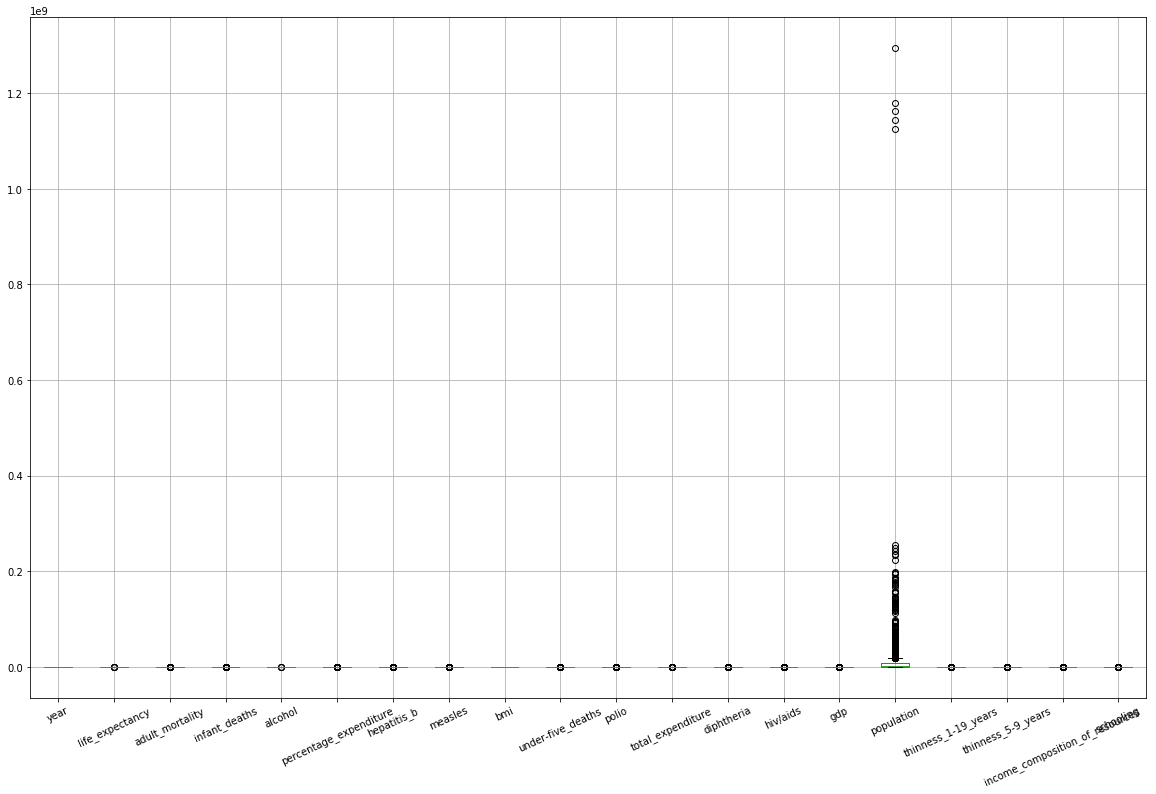

In [32]:
plt.figure(figsize=(20,15))

boxplot = df.boxplot()
plt.subplots_adjust(bottom=0.25)
plt.xticks(rotation=25)
plt.show()

Text(0.5,1,'winsorized life expectancy')

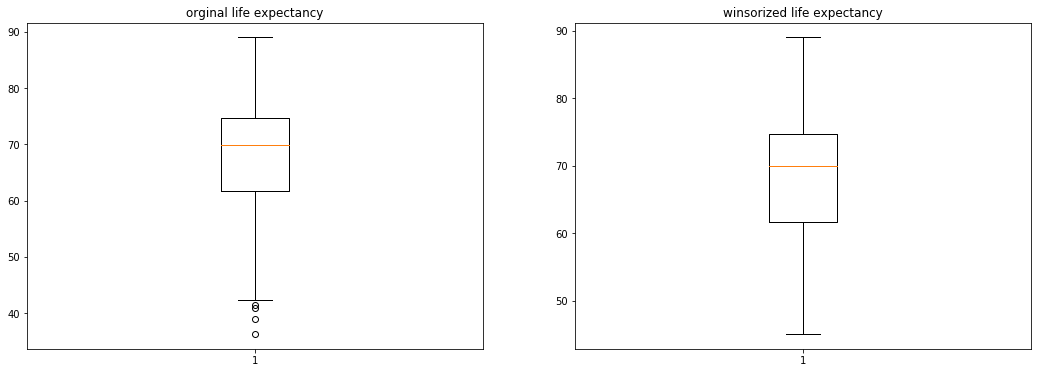

In [39]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.boxplot(df.life_expectancy)
plt.title('orginal life expectancy')

plt.subplot(1,2,2)
winsorized_life_expectancy = winsorize(df['life_expectancy'],(0.01,0),inplace=True)
plt.boxplot(winsorized_life_expectancy)
plt.title('winsorized life expectancy')

In [40]:
print(len(df))
print(len(winsorized_life_expectancy))

1987
1987
